In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# learners 
# ADD LEARNING ALGORITHMS HERE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

# decomposition
# ADD DECOMPOSITION ALGORITHMS HERE
from sklearn.preprocessing import StandardScaler


# metrics and evaluation
# ADD METRICS AND EVALUATION HERE
from sklearn.model_selection import GridSearchCV

# data
from sklearn.datasets import fetch_lfw_people


# misc
# ADD MISCELLANEOUS FUNCTIONS HERE (e.g. train_test_split)
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

plt.rcParams['image.cmap'] = "gray"
%matplotlib inline

### Load data

In [2]:
people = fetch_lfw_people(min_faces_per_person=20, resize=.7)
f"# imgs: {people.data.shape[0]} | Imgs shape: {people.images[0].shape}"

'# imgs: 3023 | Imgs shape: (87, 65)'

In [3]:
# know thy data
print(people["DESCR"])

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

#### Inspect images

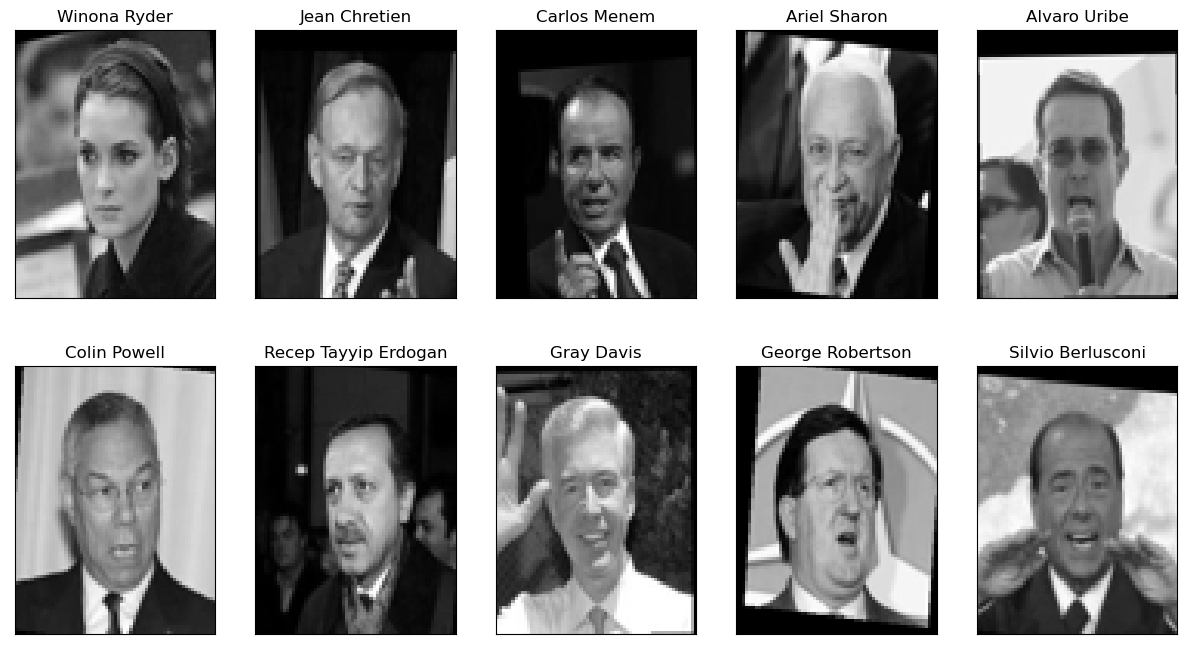

In [4]:
fig, axes = plt.subplots(
    nrows=2, 
    ncols=5, 
    figsize=(15, 8),
    subplot_kw={
        'xticks': (), 
        'yticks': ()
    }
)
for target, image, ax in zip(
    people.target, 
    people.images, 
    axes.ravel()
):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

### Filter and split images and targets

In [3]:
mask = np.zeros(people.target.shape, dtype=bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

<h1>Question 0</h1>

- Do a train_test_split of the data. Make sure you use the stratify option, to ensure the same distribution of people in training and test data

- Print the target distribution (value counts) for y_train (Consider what insights we can draw from this)

In [4]:
# Making a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people , random_state=42)

#print(y_people.shape, np.unique(y_train, return_counts=True))
pd.Series(y_train).map(pd.Series(people.target_names)).value_counts()

Donald Rumsfeld      37
Ariel Sharon         37
Junichiro Koizumi    37
Gerhard Schroeder    37
John Ashcroft        37
                     ..
Jiang Zemin          15
Igor Ivanov          15
Paul Bremer          15
Michael Bloomberg    15
Angelina Jolie       15
Length: 62, dtype: int64

#### Insights from the target distribution
Write clever words here..

# Question 1

- Build a baseline model to compare our performance against, using sklearn's `DummyClassifier`. Fit it on (X_train, y_train) and evaluate on (X_test, y_test)

- Build both a K Nearest Neighbors and a Logistic Regression model. Fit and evaluate on the same data as above. For the KNN model, set the paramter `n_neighbors` to **1**. 
- Compare the two models - Why might a KNN with n_neighbors=1 perform better? (Hint: Consider the bias/variance tradeoff)

In [5]:
# Making a function to go though the different models. The function was made in lab 2 as well.
def eval_model(model,name):
    model.fit(X_train, y_train)
    print(name)
    print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))
    print(" ")

# Preparing variables to be inserted in the function
du = DummyClassifier()
knn = KNeighborsClassifier(n_neighbors=1)
lr = LogisticRegression()

#Deploying the models via the function
eval_model(du,'Dummy Classifier')
eval_model(knn,'K Nearest Neighbor')
eval_model(lr, 'Logistic Regression')


Dummy Classifier
Accuracy on training set: 0.024
Accuracy on test set: 0.025
 
K Nearest Neighbor
Accuracy on training set: 1.000
Accuracy on test set: 0.143
 
Logistic Regression
Accuracy on training set: 0.112
Accuracy on test set: 0.093
 


#### Model comparison - KNN vs. LR

This shows that the K nearest model is overfit, because the score is 1 on training set and then the score is very poor on the test set.

The logistic regression model performs more reliable

<h1>Question 2</h1>

- Train a PCA model to (X_train, y_train). Select 100 for the number of components.

- Use the PCA model to transform both X_train and X_test. (Consider using `.fit_transform`)
- Plot the 10 (or more) first components as imgs (See section 3.4 - pp. 154 - in the book for this)

In [6]:
# For PCA, you need to scale the variables
scaler = StandardScaler()

# Scaling, fitting and transforming
X_train_Scaled = scaler.fit_transform(X_train)

#Transforming based on the fitted data
X_test_Scaled = scaler.transform(X_test)

In [7]:
# The PCA model with 100 components
pca = PCA(n_components=100)

#Fitting the model. It is unsupervised learning and therefore y_train is not necessary
pca.fit(X_train_Scaled)

# Transformiing the data
X_train_pca = pca.transform(X_train_Scaled)
X_test_pca = pca.transform(X_test_Scaled)

#Printing the shape
print("X_train_pca shape: {}".format(X_train_pca.shape))

X_train_pca shape: (1547, 100)


# Question 3
- Build a KNN model with this transformed data, and report on the results on the transformed test data. 

- Then try a Logistic Regression model, and report on the result.

- **Comment on the effect on PCA and why it occurs.**

- Bonus: Try to play around with `n_components` in your PCA model. See what the effect.

In [48]:
# Using the PCA version of X_train on a K nearest neighbor model
knn2 = KNeighborsClassifier(n_neighbors=1)

# Fitting the model
knn2.fit(X_train,y_train)

#Seeing the score on the model. With a n_neighbor of 1, the training accuracy will be 1
print("KNN score: {:.2f}".format(knn2.score(X_test,y_test)))

KNN PCA score: 0.19


In [53]:
# Using Grid search to try different neighbor values
#First params are defined
params = {'n_components':[10,50,100,150,200]}

# A PCA model is made
pca_G = PCA()

# Applying to Grid search
grid = GridSearchCV(
    estimator=pca_G,
    param_grid=params,
    cv=2,
    verbose=3
)

# Fitting to the model, and because of the verbose=3 we see all the results from the different neighbors.
grid.fit(X_train,y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END .....................n_neighbors=1;, score=0.161 total time=   0.0s
[CV 2/2] END .....................n_neighbors=1;, score=0.127 total time=   0.0s
[CV 1/2] END .....................n_neighbors=2;, score=0.129 total time=   0.0s
[CV 2/2] END .....................n_neighbors=2;, score=0.116 total time=   0.0s
[CV 1/2] END .....................n_neighbors=3;, score=0.124 total time=   0.0s
[CV 2/2] END .....................n_neighbors=3;, score=0.118 total time=   0.0s
[CV 1/2] END .....................n_neighbors=4;, score=0.137 total time=   0.0s
[CV 2/2] END .....................n_neighbors=4;, score=0.124 total time=   0.0s
[CV 1/2] END .....................n_neighbors=5;, score=0.130 total time=   0.0s
[CV 2/2] END .....................n_neighbors=5;, score=0.135 total time=   0.0s
[CV 1/2] END .....................n_neighbors=6;, score=0.130 total time=   0.0s
[CV 2/2] END .....................n_neighbors=6;,

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             verbose=3)

In [54]:


# Printing the scores and best params
print("Accuracy on training set: {:.3f}".format(grid.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(grid.score(X_test_pca, y_test)))
print("Best params: ", grid.best_params_) # Printing the best params

Accuracy on training set: 1.000
Accuracy on test set: 0.188
Best params:  {'n_neighbors': 1}


#### The effect of PCA
write clever words here..



<h1>Question 4</h1>

- Fit NMF components to the train data. Select 100 for the number of components. Use this to transform both X_train and X_test. 
- Use the same technique as from 2 to plot the components as images

- Build both a KNN model and a logistic regression model with this transformed data, and report on the result.

- Bonus: Build a neural network (MLP) - As above

- **Compare the effect of NMF with the effect of PCA**

#### Comparison of the effect of NMF and PCA

Write clever words here..

# Question 5
Let's enact a real-life case scenario, using the same data. Here, (X_train, y_train) will be the data given to your for the project. (X_test, y_test) will be *next* months batch. **Pretend it is not available to you at training time**. Follow the steps below:

- Make sure you have **ALL** random_states set to 0 (Incl. x_train_test_split's random_state!)

- Split your training data into (X_val, y_val), (X_train, y_train). Remember to set `stratify=True`

- Choose one (or more) learning algorithms discussed in class. 
- Using either NMF and PCA transform the data. Then train the the model(s) on your (X_train, y_train) and eval the results on (X_val, y_val) - To try build the best model possible
- Show the performance using an accuracy score, confusion matrix and a classification report. 
- Bonus: Report any noteworthy insights (such as class performance imbalances) and write what it might mean for your model in production.
- Fit a model to combined train and val data (i.e. the original X_train) with the best paramters. This is what we will "push to production"

# Question 6
Pretend it is next month, and you have to score the new data! (Your X_test)

- Assume that we have painstakenly annotated the data manually (y_test). 

- Evaluate your prod model on (X_test, y_test) - Report the results
- Report any noteworthy insights (such as class performance imbalances) and write what it might mean for your model in production.